In [1]:
import sys
sys.path.append('../.')
sys.path.append('../../.')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

**Load data**

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

dataset = 'credit'
X = pd.read_csv('../data/german_credit_2.csv')
target = X.pop('Creditability')
X['target']=target
X = X.dropna(axis=0)
ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("target")]
col_list = X.columns[ind]
ct = ColumnTransformer([('scaler', StandardScaler(), col_list)], remainder='passthrough')

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()
X.shape

(1000, 25)

**Fit model**

In [3]:
from sklearn.model_selection import train_test_split
from GoggleModel import GoggleModel

/home/rob/miniconda3/envs/goggle3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
X_train, X_test = train_test_split(X, random_state=1, test_size=0.2, shuffle=True)

gen = GoggleModel(
    ds_name=dataset,
    input_dim=X_train.shape[1],
    encoder_dim=64,
    encoder_l=2,
    het_encoding=True,
    decoder_dim=64,
    decoder_l=2,
    threshold=0.1,
    decoder_arch='gcn',
    graph_prior=None,
    prior_mask=None,
    device='cuda',
    beta=0.1,
    learning_rate=0.01,
    seed=0
)
gen.model

Goggle(
  (learned_graph): LearnedGraph(
    (act): Sigmoid()
    (threshold): Threshold(threshold=0.1, value=0)
  )
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): ReLU()
    )
    (encode_mu): Linear(in_features=64, out_features=25, bias=True)
    (encode_logvar): Linear(in_features=64, out_features=25, bias=True)
  )
  (graph_processor): GraphInputProcessorHomo()
  (decoder): GraphDecoderHomo(
    (decoder): Sequential(
      (0): GraphConv(
        in=64, out=32, normalization=both
        (_activation): Tanh()
      )
      (1): GraphConv(in=32, out=1, normalization=both, activation=None)
    )
  )
)

In [5]:
gen.fit(X_train)

[Epoch 100/1000, patience  1] train: 20.250, val: 20.999
[Epoch 200/1000, patience  8] train: 19.336, val: 20.385
[Epoch 300/1000, patience  6] train: 17.262, val: 18.475
[Epoch 400/1000, patience 12] train: 16.785, val: 17.984
[Epoch 500/1000, patience 36] train: 16.620, val: 17.893
Training terminated after 552 epochs


**Evaluate synthetic data**

In [6]:
X_synth = gen.sample(X_test)
X_synth.head()

,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Attribute 9,Attribute 10,...,Attribute 16,Attribute 17,Attribute 18,Attribute 19,Attribute 20,Attribute 21,Attribute 22,Attribute 23,Attribute 24,target
0,-1.254566,-0.204668,-2.350870,-0.211784,-0.699707,-1.145978,-2.376626,-0.765977,0.611613,-1.374736,...,-0.552705,-0.338862,-3.122929,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,-1.304877,1.0
1,0.336513,0.830533,1.344014,1.052817,1.199950,1.338078,0.449326,1.046987,0.611613,1.465583,...,1.809283,2.951057,0.320212,-0.206768,2.141633,0.634448,-0.149983,2.0,0.766356,2.0
2,1.132053,1.813283,1.344014,1.915423,1.833169,1.338078,1.862303,1.046987,1.564281,1.984631,...,1.809283,2.951057,0.320212,4.836346,2.141633,0.634448,-0.149983,2.0,0.766356,2.0
3,-0.459026,-0.353122,-0.503428,-0.356410,-0.699707,-0.317959,-0.963650,0.140505,-0.341055,-0.427689,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,-1.304877,1.0
4,0.336513,0.316777,1.344014,0.371832,1.199950,0.510060,0.449326,1.046987,0.611613,0.775706,...,1.809283,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,2.0


In [7]:
from synthcity.plugins.core.dataloader import GenericDataLoader
X_synth_loader = GenericDataLoader(
    X_synth,
    target_column="target",
)
X_test_loader = GenericDataLoader(
    X_test,
    target_column="target",
)

res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
print(f'Quality: {res[0]:.3f}')
print(f'Detection: {res[2]:.3f}')
print(f'Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}')

{'delta_precision_alpha_OC': 0.04733333333333334, 'delta_coverage_beta_OC': 0.052000000000000046, 'authenticity_OC': 0.96}
Quality: 0.353
Detection: 0.775
Performance on real: 0.663, on synth: 0.518


**Generate TSNE plots**

In [8]:
X_test['label'] = 'Original'
X_synth['label'] = 'Synthetic'

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df['label']
x_data = concat_df.drop(['label', 'target'], axis=1)

In [9]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

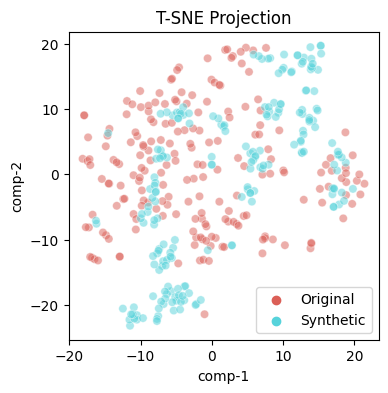

In [10]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2), alpha=0.5,
                data=df).set(title=f"T-SNE Projection")
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.legend()

plt.show()

**Visualise adjacency matrix**

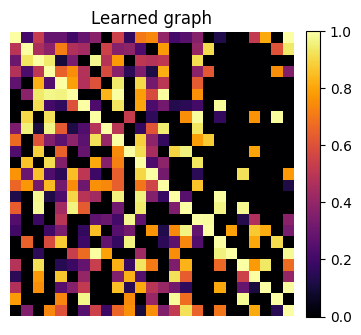

In [11]:
adj_matrix = gen.model.learned_graph(100).cpu().detach().numpy()
plt.figure(figsize=(4, 4))
im = plt.imshow(adj_matrix, cmap='inferno', interpolation='nearest', vmin=0, vmax=1.0)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Learned graph')
plt.axis('off')
plt.show()